# Sentiment Analysis Using Twitter Data

## Libraries

In [7]:
# General imports
import re
import pickle
import pandas as pd
import time

# Plotting imports
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Warnings imports
import warnings
warnings.filterwarnings("ignore")

# Nltk imports
import nltk
from nltk.stem import WordNetLemmatizer

# Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

## Helper function(s)

**There are 2 helper functions:**

- A **barrier** function that prints a horizontal line to separate printed outputs.
- A **decontracted_all** function that uses regex to replace all contractions with their corresponding **expanded** form.
    - Note that the [**'s**] contraction can indicate possession **(eg The book is John's)** or be a contraction of the long-form **word + has/is** **(eg He's a good guy)**.
    - This can create a small error where possession is concerned since an expression like "**The book is John's**" will be turned into "**The book is John has/is**".
    - However, we accept this small error while text processing as it does not adversely affect sentiment and we expect the model to be robust enough to deal with it.

In [8]:
# Barrier function
def barrier():
    print("\n <<<","-"*50,">>> \n")

# Contraction substitution function
def decontracted_all(phrase):
    phrase = re.sub(r"(can't)|(cant)", "can not", phrase)
    phrase = re.sub(r"(won't)|(wont)", "will not", phrase)
    phrase = re.sub(r"n't", " not", phrase)
    phrase = re.sub(r"'re", " are", phrase)
    phrase = re.sub(r"'s", " is", phrase)
    phrase = re.sub(r"'d", " would", phrase)
    phrase = re.sub(r"'ll", " will", phrase)
    phrase = re.sub(r"'ve", " have", phrase)
    phrase = re.sub(r"'m", " am", phrase)
    return phrase

In [9]:
# Example for decontracted_all
decontracted_all("""don't, isn't, won't, shouldn't, couldn't, wouldn't, aren't, doesn't, wasn't, weren't, hasn't,
                    haven't, hadn't, mustn't, didn't, mightn't, needn't, John's""")

'do not, is not, will not, should not, could not, would not, are not, does not, was not, were not, has not,\n                    have not, had not, must not, did not, might not, need not, John is'

**Note:**
- The above example shows how the **decontracted_all** function works for all contractions in the English language.

## Data import
**Introduction:**
- The dataset being used is the **sentiment140 dataset**.
- It contains 1,600,000 tweets extracted using the **Twitter API**.
- The tweets have been annotated **(0 = Negative, 4 = Positive)** and they can be used to detect sentiment.

**The dataset contains the following features:**
1. **sentiment**: The polarity of the tweet: (0 = negative, 4 = positive).
2. **ids**: The id of the tweet.
3. **date**: The date of the tweet.
4. **flag**: The query of the tweet. If there is no query, then this value is NO_QUERY.
5. **user**: The user that tweeted.
6. **text**: The text of the tweet.

**Note:**
- We require only the **sentiment** and **text** fields, so we can discard the other features.
- Furthermore, we're changing the **sentiment** field so that it has new values to reflect the sentiment: (**0 = Negative, 1 = Positive**)
- The data file is too large to upload to the GitHub repository but is available at https://www.kaggle.com/datasets/kazanova/sentiment140

In [10]:
# Data import
df_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
df_ENCODING = "ISO-8859-1"
# The path should be adjusted as needed to point to the csv file
df = pd.read_csv("data/data.csv", encoding=df_ENCODING , names=df_COLUMNS)
df.head(10)

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


In [11]:
# Shuffle data so that the positive and negative sentiments are randomly arranged
df = df.sample(frac=1).reset_index(drop=True)
df.head(10)

,sentiment,ids,date,flag,user,text
0,4,2051222175,Fri Jun 05 21:11:49 PDT 2009,NO_QUERY,achitnis,@aarthir Ah! Thanks for reminding me
1,0,2000976262,Mon Jun 01 23:29:07 PDT 2009,NO_QUERY,thisisjodez,is SAD!!
2,4,2060580388,Sat Jun 06 19:10:24 PDT 2009,NO_QUERY,LianeGentrySkye,@TheresaStevens Trey had a great time at the ...
3,4,1881329199,Fri May 22 04:20:21 PDT 2009,NO_QUERY,Nicola2012,@KidROO fine francis i want to be out in this...
4,0,2013970142,Wed Jun 03 00:05:10 PDT 2009,NO_QUERY,lizz_xx,@sarahz_xx did you get the sunnies ? idk if yo...
5,0,2181274616,Mon Jun 15 11:36:20 PDT 2009,NO_QUERY,drew91205,guess im single again
6,0,2068417201,Sun Jun 07 14:02:41 PDT 2009,NO_QUERY,_jas_,still has more chores to do.
7,4,2052897347,Sat Jun 06 02:27:27 PDT 2009,NO_QUERY,gidiboy4eva,@ OfficialRihanna i gotta say you where looki...
8,0,1980334937,Sun May 31 06:26:22 PDT 2009,NO_QUERY,carekoba,@dawnieboi i miss you! di kita naabutan online!
9,4,1996952864,Mon Jun 01 15:59:26 PDT 2009,NO_QUERY,CinnamonRoyalty,Off work


In [12]:
# Replacing the values for better understanding
df["sentiment"] = df["sentiment"].replace(4,1)

In [13]:
# Drop duplicates, if any
print(df.shape)
print(df.drop_duplicates().shape)

(1600000, 6)
(1600000, 6)


**Note:**
- The dataset has the same shape both before and after the drop_duplicates function.
- This suggests that there are no tweets with exactly the same information from exactly the same users on exactly the same dates.

In [14]:
# Check for any skew in the values for the sentiments
df.sentiment.value_counts()

1    800000
0    800000
Name: sentiment, dtype: int64

**Note:**
- The sentiments are perfectly split into both classes.
- There is no skew.

In [15]:
df.head()

,sentiment,ids,date,flag,user,text
0,1,2051222175,Fri Jun 05 21:11:49 PDT 2009,NO_QUERY,achitnis,@aarthir Ah! Thanks for reminding me
1,0,2000976262,Mon Jun 01 23:29:07 PDT 2009,NO_QUERY,thisisjodez,is SAD!!
2,1,2060580388,Sat Jun 06 19:10:24 PDT 2009,NO_QUERY,LianeGentrySkye,@TheresaStevens Trey had a great time at the ...
3,1,1881329199,Fri May 22 04:20:21 PDT 2009,NO_QUERY,Nicola2012,@KidROO fine francis i want to be out in this...
4,0,2013970142,Wed Jun 03 00:05:10 PDT 2009,NO_QUERY,lizz_xx,@sarahz_xx did you get the sunnies ? idk if yo...


In [16]:
# Decontract all contractions in the text column
df["text"] = df["text"].apply(decontracted_all)

In [17]:
df.head()

,sentiment,ids,date,flag,user,text
0,1,2051222175,Fri Jun 05 21:11:49 PDT 2009,NO_QUERY,achitnis,@aarthir Ah! Thanks for reminding me
1,0,2000976262,Mon Jun 01 23:29:07 PDT 2009,NO_QUERY,thisisjodez,is SAD!!
2,1,2060580388,Sat Jun 06 19:10:24 PDT 2009,NO_QUERY,LianeGentrySkye,@TheresaStevens Trey had a great time at the ...
3,1,1881329199,Fri May 22 04:20:21 PDT 2009,NO_QUERY,Nicola2012,@KidROO fine francis i want to be out in this...
4,0,2013970142,Wed Jun 03 00:05:10 PDT 2009,NO_QUERY,lizz_xx,@sarahz_xx did you get the sunnies ? idk if yo...


[Text(0, 0, 'Negative'), Text(1, 0, 'Positive')]

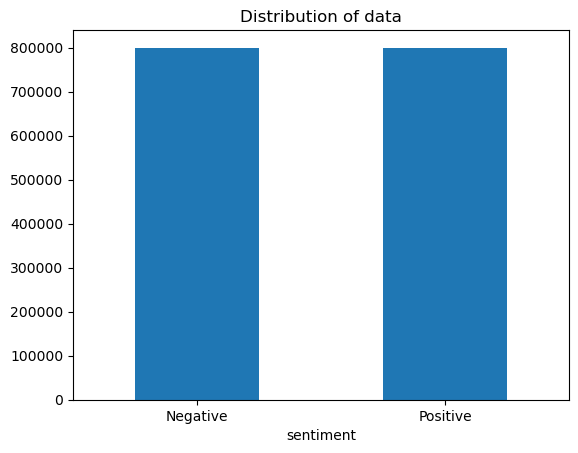

In [18]:
# Removing the unnecessary columns
df = df[["sentiment", "text"]]
# Plotting the distribution for sentiment count
ax = df.groupby("sentiment").count().plot(kind="bar", title="Distribution of data", legend=False)
ax.set_xticklabels(["Negative","Positive"], rotation=0)

## Data wrangling
- Data wrangling in Natural Language Processing (NLP) largely involvesText Processing.
- Text Processing transforms text into a more pliable form for machine learning algorithms.

**The data wrangling steps taken are:**
1. Lower casing
2. Replacing URLs with the word "URL"
3. Replacing emojis eg: converting :) to EMOJIsmile
4. Replacing usernames with word "USER"
5. Replacing non-alphanumeric characters with a space
6. Removing consecutive letters eg:"Heyyyy" to "Heyy"
7. Lemmatization

**Note:**
- The removal of stop words is optionally available and commented out in the code below.
- Model tuning suggested that accuracy was worsened by the removal of stop words.
    - This is because stop words include words that indicate negation (eg can't, wouldn't, not, don't etc) which strongly affect sentiment.
- Consequently, I have opted to leave them **in** the corpus.

In [19]:
# Mapping of all emojis with their meanings
emojis = {":)":"smile", ":-)":"smile", ";d":"wink", ":-E":"vampire", ":(":"sad", 
          ":-(":"sad", ":-<":"sad", ":P":"raspberry", ":O":"surprised",
          ":-@":"shocked", ":@":"shocked", ":-$":"confused", ":\\":"annoyed", 
          ":#":"mute", ":X":"mute", ":^)":"smile", ":-&":"confused", "$_$":"greedy",
          "@@":"eyeroll", ":-!":"confused", ":-D":"smile", ":-0":"yell", "O.o":"confused",
          "<(-_-)>":"robot", "d[-_-]b":"dj", ":'-)":"sadsmile", ";)":"wink", 
          ";-)":"wink", "O:-)":"angel","O*-)":"angel","(:-D":"gossip", "=^.^=":"cat"}
# Stopwords
stopwords = nltk.corpus.stopwords.words("english")

In [20]:
# Function that carries out all pre-processing steps
def preprocess(text_data):
    processed_text = []
    # Create lemmatizer
    word_lemm = WordNetLemmatizer()
    # Defining regex patterns
    url_pattern = r"((http://)[^ ]*|(https://)[^ ]*|(www.)[^ ]*)"
    user_pattern = r"@[^\s]+"
    alpha_pattern = r"[^a-zA-Z0-9]"
    sequence_pattern = r"(.)\1\1+"
    seq_replace_pattern = r"\1\1"
    # Cleaning
    for tweet in text_data:
        # Lower case
        tweet = tweet.lower()
        # Replace all URls with "URL"
        tweet = re.sub(url_pattern, "URL", tweet)
        # Replace all emojis
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME with "USER"
        tweet = re.sub(user_pattern, "USER", tweet)       
        # Replace all non-alphanumeric characters
        tweet = re.sub(alpha_pattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letters
        tweet = re.sub(sequence_pattern, seq_replace_pattern, tweet)
        # Lemmatizing
        words = tweet.split()
        words_cleaned = []
        
        for word in words:
            words_cleaned.append(word_lemm.lemmatize(word))
        
        # # OPTIONAL - Stop word removal
        # words_cleaned = [i for i in words_cleaned if i not in stopwords]
        
        # Re-combination
        processed_text.append(" ".join(words_cleaned))
    
    return processed_text

In [21]:
# Timing
start = time.time()
processedtext = preprocess(df["text"])
print(f"Time Taken: {round(time.time() - start)} seconds.")

Time Taken: 120 seconds.


## EDA

In [22]:
df["text"][df["sentiment"]==0].values

array(['is SAD!!  ',
       '@sarahz_xx did you get the sunnies ? idk if you could hear me properly on the phone haha.. i has a sore throat ',
       'guess im single again ', ...,
       '@shermaineee ME TOO  !! ugh but no choice. I had my fair share of afternoon classes and squeezing into peak hour trains. H8 H8 H8',
       'Too warm to cook anything warm. I might just have rolls+coldmeat+crisps for dinner. SO. WARM. ',
       "had forgotten it was the Harbourside estival this weekend. Do not think we'l be going in this rain "],
      dtype=object)

In [23]:
# Separate the negative and positive sentiment tweets
text_negative = df["text"][df["sentiment"]==0].values
text_positive = df["text"][df["sentiment"]==1].values

### Word-cloud for negative tweets

**Note:**
- The wordcloud code below takes a significant amount of time to run due to the size of the dataset. The image was generated once, saved and then referenced in the notebook using markdown.
- The code can be uncommented and re-run if needed

In [1]:
# plt.figure(figsize=(20,20))
# wc = WordCloud(max_words= 1000, width=1600, height=800, collocations=False).generate(" ".join(text_negative))
# plt.imshow(wc)
# plt.show()

![word cloud negative](data/word_cloud_negative.png)

### Word-cloud for positive tweets

**Note:**
- The wordcloud code below takes a significant amount of time to run due to the size of the dataset. The image was generated once, saved and then referenced in the notebook using markdown.
- The code can be uncommented and re-run if needed

In [2]:
# plt.figure(figsize = (20, 20))
# wc = WordCloud(max_words=1000 , width=1600 , height=800, collocations=False).generate(" ".join(text_positive))
# plt.imshow(wc)
# plt.show()

![word cloud positive](data/word_cloud_positive.png)

## Pre-processing

### Splitting the data

In [26]:
sentiment = df["sentiment"].values

In [27]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment, test_size=0.2,
                                                    stratify=sentiment, random_state=123)

In [28]:
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

1280000
320000
1280000
320000


### Transforming the data

In [29]:
# Use the tfidfvectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectorizer.fit(X_train)

TfidfVectorizer(max_features=500000, ngram_range=(1, 2))

**NOTE:**
- We set `ngram_range` to (1,2) meaning we ue single words as well as bi-grams in our model.

In [30]:
print("No. of feature_words: ", len(vectorizer.get_feature_names_out()))

No. of feature_words:  500000


In [31]:
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

In [32]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1280000, 500000)
(320000, 500000)
(1280000,)
(320000,)


**NOTE:**
- **Tf-idf** or **Term Frequency Inverse Document Frequency** will weight the words according to their importance in the corpus.
- Words that are frequent in one document but not in the corpus as a whole will be weighted favorably over words that are common to all documents.

## Saving data, vectorizer and models

In [33]:
file = open("models/vectorizer.pickle","wb")
pickle.dump(vectorizer, file)
file.close()

file = open("models/X_train.pickle","wb")
pickle.dump(X_train, file)
file.close()

file = open("models/X_test.pickle","wb")
pickle.dump(X_test, file)
file.close()

file = open("models/y_train.pickle","wb")
pickle.dump(y_train, file)
file.close()

file = open("models/y_test.pickle","wb")
pickle.dump(y_test, file)
file.close()

file = open("models/processedtext.pickle","wb")
pickle.dump(processedtext, file)
file.close()

file = open("models/df_pre_modeling.pickle","wb")
pickle.dump(df, file)
file.close()

## Next steps

**Note:**
- The dataset is very large and many steps in this notebook can be time consuming to run.
- To keep the flow of information palatable and legible, this project has been split into three notebooks
    - Part 2-1 and Part 2-2 are contained with the same project folder as this Part 1.
    - See https://github.com/Daolaiya/Data-Science-Portfolio/tree/main/Project%203
    - Please run them one at a time and in order.